# xgBoost : Baseline model on Resturant data

In [2]:
# COLAB
from google.colab import files
from google.colab import drive
# SYS
import sys
# IPYNB
!pip install import-ipynb
import import_ipynb
# UTIL
import importlib.util

In [3]:
import pandas as pd
import re
import numpy as np
from sklearn import linear_model, metrics  
import xgboost as xgb 
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading preprocessing class

In [1]:
#https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python
sys.path.append('/content/gdrive/MyDrive/CS--2/')
#import module_1_xml_to_df
#from module_1_xml_to_df import convert_xml_to_DataFrame
from module_2_preprocessing import Data_Preprocessing

NameError: name 'sys' is not defined

## 1.Loading the data

In [7]:
restaurant_data= pd.read_csv("/content/gdrive/MyDrive/CS--2/restaurant_train_data_semeval_14.csv")

In [8]:
restaurant_data.shape

(3044, 5)

In [9]:
restaurant_data.head()

,id,text,aspect_term,aspect_category,polarity
0,3121,but the staff was so horrible to us.,staff,service,negative
1,2777,"to be completely fair, the only redeeming fact...",food,anecdotes/miscellaneous,negative
2,1634,"the food is uniformly exceptional, with a very...",menu,food,positive
3,2534,where gabriela personaly greets you and recomm...,NaN,service,positive
4,583,"for those that go once and don't enjoy it, all...",NaN,anecdotes/miscellaneous,positive


In [10]:
restaurant_data.groupby('aspect_category').size().sort_values(ascending=False)

aspect_category
anecdotes/miscellaneous    1040
food                        870
service                     466
ambience                    387
price                       281
dtype: int64

In [11]:
catagories = restaurant_data['aspect_category'].unique()
catagories , len(catagories)

(array(['service', 'anecdotes/miscellaneous', 'food', 'price', 'ambience'],
       dtype=object), 5)

In [12]:
polarity = restaurant_data['polarity'].unique()
polarity

array(['negative', 'positive', 'neutral', 'conflict'], dtype=object)

## 2. Aspect Based Sentiment Analysis

In [14]:
X = restaurant_data['text']
Y = restaurant_data['aspect_category']

### 2.1 Splitting the data 

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2435,) (2435,)
(609,) (609,)


In [18]:
dp = Data_Preprocessing()

In [19]:
X_train_review = dp.preprocess_text(X_train)

100%|██████████| 2435/2435 [00:02<00:00, 893.95it/s]


In [20]:
X_test_review = dp.preprocess_text(X_test)

100%|██████████| 609/609 [00:00<00:00, 2739.45it/s]


### 2.2 xgBoost model

In [21]:
from sklearn.feature_extraction.text import CountVectorizer    
vectorizer_sit = CountVectorizer(min_df=3,max_features=50000)  
vectorizer_sit.fit(X_train_review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=50000, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [22]:
preprocessed_train_review = vectorizer_sit.transform(X_train_review).toarray()    # produces a sparse representation of preprocessed sentences
print("Shape of matrix data after one hot encoding for train: ",preprocessed_train_review .shape)

Shape of matrix data after one hot encoding for train:  (2435, 1183)


In [23]:
preprocessed_test_review = vectorizer_sit.transform(X_test_review).toarray()    
print("Shape of matrix data after one hot encoding for train: ",preprocessed_test_review.shape)

Shape of matrix data after one hot encoding for train:  (609, 1183)


In [24]:
reg = xgb.XGBClassifier() 
reg.fit(preprocessed_train_review, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
# making predictions on the training set 
y_pred_train = reg.predict(preprocessed_train_review)

In [26]:
# making predictions on the testing set 
y_pred_cat = reg.predict(preprocessed_test_review)

In [27]:
# comparing actual response values (y_train) with predicted response values (y_pred_train) 
metrics.accuracy_score(y_train, y_pred_train)*100

73.59342915811088

In [28]:
# comparing actual response values (y_test) with predicted response values (y_pred_cat) 
metrics.accuracy_score(y_test, y_pred_cat)*100

65.02463054187191

### 2.3. Classification Report

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cat ,target_names=catagories))

                         precision    recall  f1-score   support

                service       0.80      0.32      0.46        75
anecdotes/miscellaneous       0.61      0.86      0.71       204
                   food       0.65      0.70      0.68       183
                  price       0.63      0.35      0.45        63
               ambience       0.78      0.55      0.64        84

               accuracy                           0.65       609
              macro avg       0.69      0.56      0.59       609
           weighted avg       0.67      0.65      0.63       609



### Observation : 
This is the classification report of aspect category based sentiment model of xgbbost showing the precision, recall, f1_score and support values for all 5 unique catagories with accuracy 60 percent 

### 2.4. Confusion matrix Representation

In [32]:
# code borrowed from Microsoft Malware Detection Assignment
def plot_confusion_matrix(test_y, predict_y ,labels):
    C = confusion_matrix(test_y, predict_y)      # calculation of confusion matrix 
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y))    # number of misclassified points while predicting y
 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = labels                 
    cmap=sns.light_palette("purple")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.3497536945812808
-------------------------------------------------- Confusion matrix --------------------------------------------------


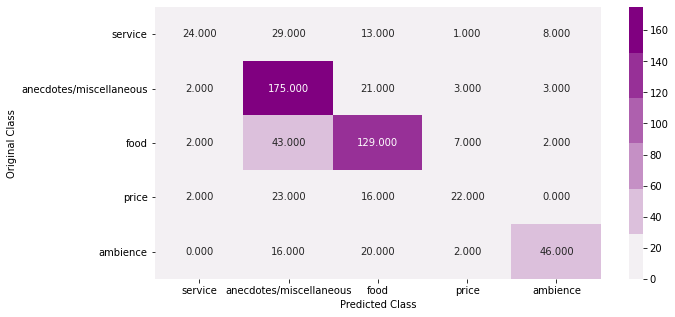

-------------------------------------------------- Precision matrix --------------------------------------------------


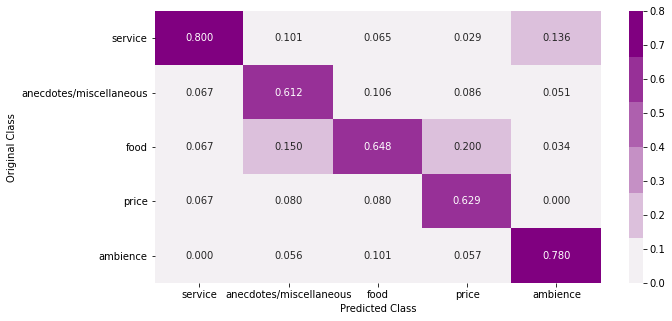

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


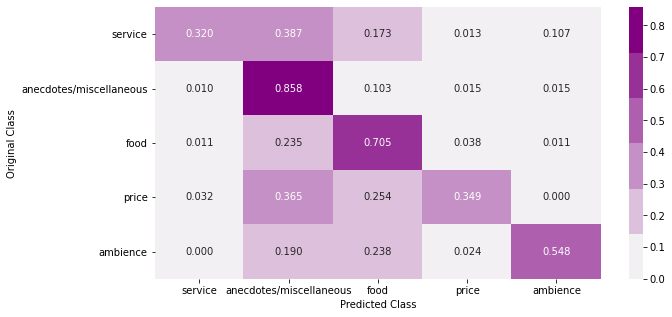

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [33]:
plot_confusion_matrix(y_test,  y_pred_cat, catagories)

## 3.Polarity Based sentiment model

In [35]:
X = restaurant_data['text']
Y = restaurant_data['polarity']

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [37]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2435,) (2435,)
(609,) (609,)


In [38]:
reg = xgb.XGBClassifier() 
reg.fit(preprocessed_train_review, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
# making predictions on the training set 
y_pred_train = reg.predict(preprocessed_train_review)

In [40]:
# making predictions on the testing set 
y_pred_polarity = reg.predict(preprocessed_test_review)

In [41]:
# comparing actual response values (y_train) with predicted response values (y_pred_train) 
 
metrics.accuracy_score(y_train, y_pred_train)*100

68.25462012320328

In [42]:
metrics.accuracy_score(y_test, y_pred_polarity)*100

58.45648604269294

Number of misclassified points  0.4154351395730706
-------------------------------------------------- Confusion matrix --------------------------------------------------


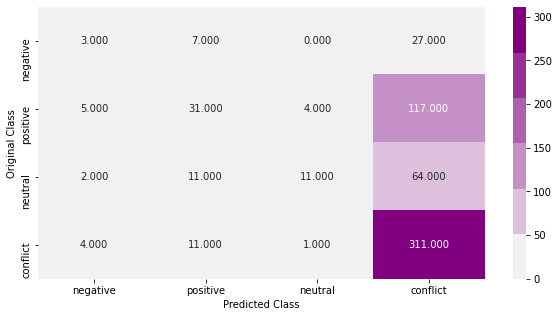

-------------------------------------------------- Precision matrix --------------------------------------------------


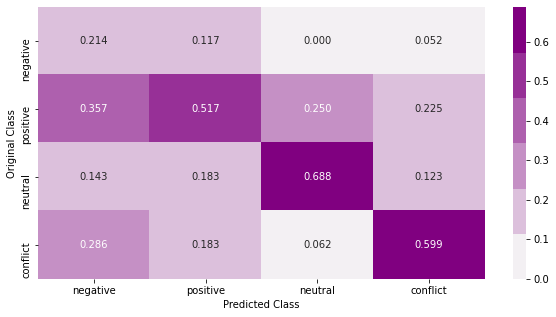

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


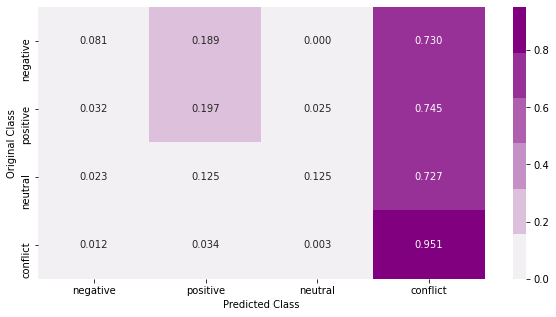

Sum of rows in precision matrix [1. 1. 1. 1.]


In [43]:
plot_confusion_matrix(y_test,  y_pred_polarity, polarity)

## 4. creating a resultant dataframe

In [45]:
def create_result_dataframe(pred_1,pred_2):
  # Calling DataFrame constructor on predicted outputs
  resultant_df = pd.DataFrame(list(zip(pred_1,pred_2)), columns = ["predicted_catagories" , "predicted_polarity"])
  result  = pd.crosstab(resultant_df.predicted_catagories,resultant_df.predicted_polarity ,margins = True , margins_name = "Total")
  result["Ranking"] = ( result.Total/resultant_df.shape[0]) * 5.0 
  result["Negative in %"] = (result.negative/result.Total) * 100
  result["Neutral in %"] = (result.neutral/result.Total) * 100
  result["Positive in %"] = (result.positive/result.Total) * 100
  result["conflict in %"] = (result.conflict/result.Total) * 100
  del result["negative"]
  del result["neutral"]
  del result["positive"]
  del result["Total"]
  del result["conflict"]

  return result


In [46]:
result = create_result_dataframe(y_pred_cat,y_pred_polarity)

In [47]:
result

predicted_polarity,Ranking,Negative in %,Neutral in %,Positive in %,conflict in %
predicted_catagories,,,,,
ambience,0.246305,13.333333,0.000000,86.666667,0.000000
anecdotes/miscellaneous,2.348112,9.090909,5.244755,84.265734,1.398601
food,1.633826,9.045226,0.502513,86.934673,3.517588
price,0.287356,17.142857,0.000000,77.142857,5.714286
service,0.484401,10.169492,0.000000,88.135593,1.694915
Total,5.000000,9.852217,2.627258,85.221675,2.298851


### Observation :
   Above result shows that the Ranking and all Polarities in percentages for all aspect catagories from which we can see that anecdotes/miscellaneous have the highest ranking of 1.34 . and service catagory have highest positive polarity